In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import struct
import functions as datahelper
from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
def loadpb(filename, model_name='dcgan'):
    """Loads pretrained graph from ProtoBuf file
    Arguments:
        filename - path to ProtoBuf graph definition
        model_name - prefix to assign to loaded graph node names
    Returns:
        graph, graph_def - as per Tensorflow definitions
    """
    with tf.gfile.GFile(filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def,
                            input_map=None,
                            return_elements=None,
                            producer_op_list=None,
                            name=model_name)

    return graph, graph_def

In [3]:
tf.reset_default_graph()

# hyperparameters -- TODO save in config file
batch_size=64
z_dim = 100 # random noise vector dimension 

beta1=0.5 # β1 Adam training param
learning_rate = 0.0002
lmda = 0.003 # λ ratio for prior loss

epochs = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

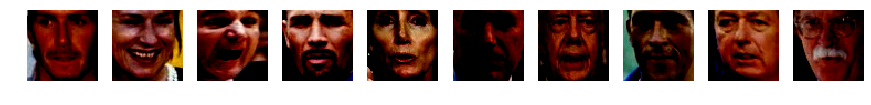

In [4]:
# data TODO
image_shape = (64, 64, 3)

generator_input = tf.placeholder(tf.float32, shape=(batch_size, z_dim), name="gen_input") # vec from uniform distr. [-1, 1]
# discriminator_input = tf.placeholder(tf.float32, shape=(batch_size*2, 64, 64, 3))

mask = tf.placeholder(tf.float32, shape=image_shape)


dataset = tf.data.TFRecordDataset(filenames="./data/data.tfrecord")
dataset  = dataset.map(datahelper.extract_fn)

# dataset = tf.data.TFRecordDataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=300)
dataset = dataset.batch(batch_size)


iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
init_op = iterator.make_initializer(dataset)

# batched data to feed in
image_data = iterator.get_next()
image_data = tf.cast((image_data/255)*2  - 1, dtype=tf.float32)

# visualize original data
with tf.Session() as sess:
    sess.run(init_op)
    img = np.array(sess.run(image_data))
    fig, ax = plt.subplots(1,10,figsize=(15,15))
    for i in range(10):
        _img = img[i,:,:,:]
        ax[i].imshow(_img)
        ax[i].axis('off')

In [5]:
graph, graph_def = loadpb("dcgan-100.pb")

g_in = graph.get_tensor_by_name('dcgan' +'/'+ 'z:0')
g_out = graph.get_tensor_by_name('dcgan'+'/'+ 'Tanh:0')
g_loss = graph.get_tensor_by_name('dcgan'+'/'+ 'Mean_2:0')
d_in = graph.get_tensor_by_name('dcgan'+'/'+ 'real_images:0')
d_out = graph.get_tensor_by_name('dcgan' +'/'+ 'Sigmoid:0')

In [6]:
with tf.Session(graph=graph) as sess:
    z = np.random.randn(batch_size, z_dim)
    sample_out = sess.run(g_out, feed_dict={g_in: z})


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


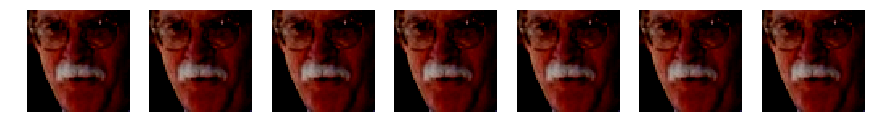

In [7]:
fig, ax = plt.subplots(1,7,figsize=(15,15))
for i in range(7):
    img = sample_out[i,:,:,:]
    ax[i].imshow(_img)
    ax[i].axis('off')